In [1]:
import os
localfs_path = os.environ.get('SCRATCH_LOCAL') + '/'

In [2]:
os.environ['_JAVA_OPTIONS'] = f'-Djava.io.tmpdir={localfs_path}'

import hail as hl

hl.init(
    tmp_dir=(localfs_path+'tmp_hail_3'),
    default_reference='GRCh38'
) 

Picked up _JAVA_OPTIONS: -Djava.io.tmpdir=/localfs/4692906/
Picked up _JAVA_OPTIONS: -Djava.io.tmpdir=/localfs/4692906/


23/09/11 15:07:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.2
SparkUI available at http://ac0548:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.113-cf32652c5077
LOGGING: writing to /net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-gts/preprocessing/oligogenic-model/hail-20230911-1506-0.2.113-cf32652c5077.log


In [3]:
from hail.plot import show
from pprint import pprint
from bokeh.layouts import gridplot
import numpy as np
hl.plot.output_notebook()
import bokeh
from scipy import stats

from bokeh.plotting import figure, output_notebook, show
output_notebook

Loading BokehJS ...

<function bokeh.io.output.output_notebook(resources=None, verbose=False, hide_banner=False, load_timeout=5000, notebook_type='jupyter')>

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from oligogenic_model import (
    read_in_pheno_anno_all,
    read_in_pheno_anno_sport
)

### count cases

In [12]:
mt = read_in_pheno_anno_all(
    '/net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-gts/data/mts/oligogenic-model/gts_and_s.mt',
    'all')

2023-09-07 08:58:01.238 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (not specified)
  Loading field 'f1' as type str (not specified)
  Loading field 'f2' as type str (not specified)
  Loading field 'f3' as type str (not specified)
  Loading field 'f4' as type str (not specified)
  Loading field 'f5' as type str (not specified)
  Loading field 'f6' as type str (not specified)
  Loading field 'f7' as type str (not specified)
  Loading field 'f8' as type str (not specified)
2023-09-07 08:58:02.270 Hail: INFO: Reading table without type imputation
  Loading field 'Gene stable ID' as type str (not specified)
  Loading field 'UniProtKB Gene Name symbol' as type str (not specified)
2023-09-07 08:58:03.484 Hail: INFO: Reading table to impute column types
2023-09-07 08:58:04.521 Hail: INFO: Finished type imputation
  Loading field 'ID' as type str (imputed)
  Loading field 'family' as type str (imputed)
  Loading field 'sex' as type str (imputed)
  Loading

In [13]:
mt = mt.naive_coalesce(100)

In [14]:
mt = mt.checkpoint(localfs_path+'repart.mt')

2023-09-07 09:35:55.169 Hail: INFO: wrote matrix table with 6538550 rows and 287 columns in 100 partitions to /localfs/4692906/repart.mt


In [9]:
mt = hl.read_matrix_table(localfs_path+'repart.mt')

In [10]:
mt.aggregate_cols(hl.agg.counter(mt.phenotypes.family))

{'.': 40,
 'A': 7,
 'B': 8,
 'C': 9,
 'D': 7,
 'E': 7,
 'F': 11,
 'G': 4,
 'H': 6,
 'I': 6,
 'J': 5,
 'K': 3,
 'L': 3,
 'M': 3,
 'N': 3,
 'O': 3,
 'P': 4,
 'R': 6,
 'S': 6,
 'T': 9,
 'U': 5,
 'W': 15,
 'X': 5,
 'Y': 8,
 'Z': 2,
 None: 102}

In [11]:
samples_to_exclude = ['S_7288', 'S_7289', 'S_7290', 'WGS_6827', 'WGS_6835', 'WGS_5', 'WGS_8']

In [12]:
mt = mt.filter_cols(
    hl.literal(samples_to_exclude).contains(mt.s),
    keep = False
)

### count GTS subgroups

In [13]:
mt.count()

(6538550, 280)

In [14]:
gts = mt.filter_cols(mt.group == 'GTS')

In [15]:
gts.count()

(6538550, 178)

In [16]:
gts1 = gts.filter_cols(gts.phenotypes.family == '.')

In [17]:
gts1.count()

(6538550, 37)

In [18]:
gts1.aggregate_cols(hl.agg.counter(gts1.phenotypes.sex))

{'F': 6, 'M': 31}

In [21]:
for com in ['ADHD','ANX','MDD','OCD','ASD','SCHI']:
    
    print(com)
    print(
        gts1.aggregate_cols(
            hl.agg.count_where(
                gts1.phenotypes.add_pheno.contains(com)
            )
        )
    )

ADHD
17
ANX
20
MDD
16
OCD
14
ASD
4
SCHI
1


In [22]:
gts2 = gts.filter_cols(gts.phenotypes.family == '.', keep = False)

In [23]:
gts2.count()

(6538550, 141)

In [36]:
for com in ['ADHD','ANX','MDD','OCD','ASD','SCHI']:
    
    print(com)
    print(
        gts.aggregate_cols(
            hl.agg.count_where(
                gts.phenotypes.add_pheno.contains(com)
            )
        )
    )

ADHD
20
ANX
30
MDD
23
OCD
24
ASD
11
SCHI
1


In [37]:
for com in ['ADHD','ANX','MDD','OCD','ASD','SCHI']:
    
    print(com)
    print(
        gts1.aggregate_cols(
            hl.agg.count_where(
                gts1.phenotypes.add_pheno.contains(com)
            )
        )
    )

ADHD
17
ANX
20
MDD
16
OCD
14
ASD
4
SCHI
1


In [29]:
for com in ['ADHD','ANX','MDD','OCD','ASD','SCHI']:
    
    print(com)
    print(
        gts2.aggregate_cols(
            hl.agg.group_by(
                gts2.phenotypes.phenotype,
                hl.agg.count_where(
                    gts2.phenotypes.add_pheno.contains(com)
                )
            )
        )
    )

ADHD
{'.': 0, 'GTS': 3, 'tics': 0}
ANX
{'.': 0, 'GTS': 10, 'tics': 0}
MDD
{'.': 1, 'GTS': 6, 'tics': 0}
OCD
{'.': 0, 'GTS': 6, 'tics': 4}
ASD
{'.': 1, 'GTS': 5, 'tics': 1}
SCHI
{'.': 0, 'GTS': 0, 'tics': 0}


In [ ]:
gts2.aggregate_cols(
    hl.agg.counter(
        gts2.phenotypes.heavy_tics_familial
    )
)

In [ ]:
gts2.aggregate_cols(
    hl.agg.counter(
        gts2.phenotypes.phenotype
    )
)

In [40]:
gts2.aggregate_cols(
    hl.agg.group_by(
        gts2.phenotypes.phenotype,
        hl.agg.counter(
            gts2.phenotypes.add_phen
        )
    )
)

{'.': {'.': 53, 'ASD': 1, 'MDD': 1},
 'GTS': {'.': 28,
  'ADHD': 1,
  'ADHDANX': 1,
  'ADHDOCDMDDANX': 1,
  'ANX': 5,
  'ASD': 5,
  'OCDMDD': 2,
  'OCDMDDANX': 3},
 'tics': {'.': 35, 'ASD': 1, 'OCD': 4}}

In [ ]:
gts1.aggregate_cols

### len of selected gene lists

In [14]:
gene_list = ['DCC', 'RBFOX', 'SLC30A9', 'DCAF4L1', 'SORCS3', 'KCNQ5', 'KCNQ-IT1', 'APOPT1', 'C14orf2', 'NAA11', 'NEGR1',
        'CHADL', 'SOX5', 'PANK2', 'COL27A1', 'PDGFB', 'CELSR3', 'OPA1', 'FBN2', 'WWC1', 'NIPBL', 
             'FN1', 'FBN2', 'SLITRK1', 'SLITRK2', 'SLITRK3', 'SLITRK4', 'SLITRK5', 'SLITRK6', 
             'HDC', 'OPRK1', 'PCDH10', 'NTSR2', 'CHD8', 'SCUBE1', 'PNKD', 'CNTNAP2', 'MOG', 
             'DRD2', 'DRD3', 'DRD4', 'DRD5', 'DAT1', 'DBH', 'HTR2A', 'TPH2', 'EAAT1', 'SAPAP3',
            'CTNNA3', 'NLGN4', 'FSCB', 'IMMP2L', 'NRXN1', 'AADAC', 'DBH', 'MAOA', 'HTR1A', 'HTR2C', 'SLC6A4',
             'TPH2', 'COL27A1', '5-HTTLPR', 'EAAT1', 'COL8A1', 'KCNE1', 'KCNE2',
         'RICTOR', 'WWC1', 'CELSR3, NIPBL', 'FN1', 'PNKD', 'CDH26', 'CADM2', 'OPCML', 'CDH9',
         'NCAM2', 'CD47', 'CDH5', 'CADM4', 'C1QBP', 'CTTN', 'LSAMP',
         'PKP4', 'PCDH1', 'CNTNAP2', 'MBP', 'GABBR2', 'GABBR2', 'GRIK4', 'NCR1', 'FLT3', 'IL12A', 'HDAC9',
         'CD180', 'CDH26', 'NCAM2', 'NTM', 'ROBO2', 'NR2F1', 'ASH1L', 'FLT3']

In [15]:
len(gene_list)

101

### how many variants in the model?

In [38]:
mt = read_in_pheno_anno_sport(
    '/net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-gts/data/mts/oligogenic-model/gts_and_s.mt',
    'gts_sport_for_vars'
)

2023-09-07 13:18:27.231 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (not specified)
  Loading field 'f1' as type str (not specified)
  Loading field 'f2' as type str (not specified)
  Loading field 'f3' as type str (not specified)
  Loading field 'f4' as type str (not specified)
  Loading field 'f5' as type str (not specified)
  Loading field 'f6' as type str (not specified)
  Loading field 'f7' as type str (not specified)
  Loading field 'f8' as type str (not specified)
2023-09-07 13:18:27.914 Hail: INFO: Reading table without type imputation
  Loading field 'Gene stable ID' as type str (not specified)
  Loading field 'UniProtKB Gene Name symbol' as type str (not specified)
2023-09-07 13:18:28.852 Hail: INFO: Reading table to impute column types
2023-09-07 13:18:29.626 Hail: INFO: Finished type imputation
  Loading field 'ID' as type str (imputed)
  Loading field 'family' as type str (imputed)
  Loading field 'sex' as type str (imputed)
  Loading

In [15]:
mt = hl.read_matrix_table(localfs_path+'repart.mt')

In [16]:
genes = ['CHADL', 'DRD2', 'MAOA', 'PCDH10', 'HTR2A', 'SLITRK5', 'SORCS3', 'KCNQ5', 'CDH9', 'CHD8']

In [17]:
mt = mt.filter_rows(
    hl.literal(genes).contains(mt.nearest_genes_20kb)
)

In [18]:
mt = mt.filter_rows(mt.cadd.score_phred > 0)

In [ ]:
sel_mt = mt.checkpoint(localfs_path+'filtered_sel.mt')

In [7]:
sel_mt = hl.read_matrix_table(localfs_path+'filtered_sel.mt')

In [8]:
sel_mt.count()

(7654, 287)

In [9]:
sel_mt.aggregate_cols(hl.agg.counter(sel_mt.group))

{'GTS': 185, 'local_controls': 102}

In [10]:
samples_to_exclude = ['S_7288', 'S_7289', 'S_7290', 'WGS_6827', 'WGS_6835', 'WGS_5', 'WGS_8', 'B502', 'B506']

In [11]:
sel_mt = sel_mt.filter_cols(
    hl.literal(samples_to_exclude).contains(sel_mt.s),
    keep = False
)

In [12]:
sel_mt.aggregate_rows(hl.agg.approx_median(sel_mt.gnomad_v_3_1.freq.AF[2]))

0.024275841787972357

In [51]:
mafs = sel_mt.filter_rows(hl.is_defined(sel_mt.gnomad_v_3_1.freq.AF[2]))

In [55]:
all_ass = mafs.gnomad_v_3_1.freq.AF[2].collect()

In [64]:
for i, num in enumerate(all_ass):
    if num > 0.5:
        num = 1 - num
        all_ass[i] = num

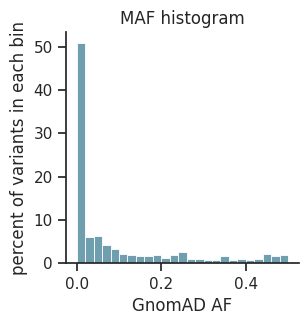

In [66]:
sns.histplot(
    all_ass,
    bins=50,
    stat="percent",
    binrange=[0,0.5],
    binwidth=0.02,
    color=sns.diverging_palette(220, 20)[0]
)
        
plt.title('MAF histogram')
plt.xlabel('GnomAD AF')
plt.ylabel('percent of variants in each bin')
sns.set_style("ticks")
sns.despine()

plt.savefig("hists.png")

In [13]:
sel_mt = sel_mt.annotate_cols(
    gts = hl.if_else(
        sel_mt.group == 'local controls',
        'NO',
        sel_mt.phenotypes.disease
    )
)

In [16]:
sel_mt = sel_mt.annotate_rows(
    af_per_group = hl.agg.group_by(
        sel_mt.gts,
        hl.agg.call_stats(
            sel_mt.GT, sel_mt.alleles
        )
    )
)


In [20]:
gts_over = sel_mt.filter_rows(
    sel_mt.af_per_group['NO']['AF'][1] < sel_mt.af_per_group['YES']['AF'][1]
)

In [22]:
gts_over.count()

(3807, 278)

In [103]:
veps = gts_over.aggregate_rows(
    hl.agg.counter(gts_over.vep.vep.most_severe_consequence)
)

In [94]:
#veps.pop('intron_variant')

3111

In [105]:
for key, value in veps.items():
    veps[key] = value*100/3807

In [106]:
sum(veps.values())

100.0

In [107]:
veps = dict(sorted(veps.items(), key=lambda item: item[1], reverse=True))

In [108]:
veps.values()

dict_values([81.71788810086683, 5.621224060940373, 2.8894142369319673, 2.8631468347780404, 1.9700551615445232, 1.7073811400052534, 1.4447071184659837, 0.9981612818492251, 0.42027843446283164, 0.18387181507748884, 0.15760441292356187, 0.026267402153926978])

In [110]:
veps

{'intron_variant': 81.71788810086683,
 'intergenic_variant': 5.621224060940373,
 '3_prime_UTR_variant': 2.8894142369319673,
 'non_coding_transcript_exon_variant': 2.8631468347780404,
 'downstream_gene_variant': 1.9700551615445232,
 'synonymous_variant': 1.7073811400052534,
 'upstream_gene_variant': 1.4447071184659837,
 'missense_variant': 0.9981612818492251,
 'regulatory_region_variant': 0.42027843446283164,
 '5_prime_UTR_variant': 0.18387181507748884,
 'splice_region_variant': 0.15760441292356187,
 'splice_donor_variant': 0.026267402153926978}

IndexError: list index out of range

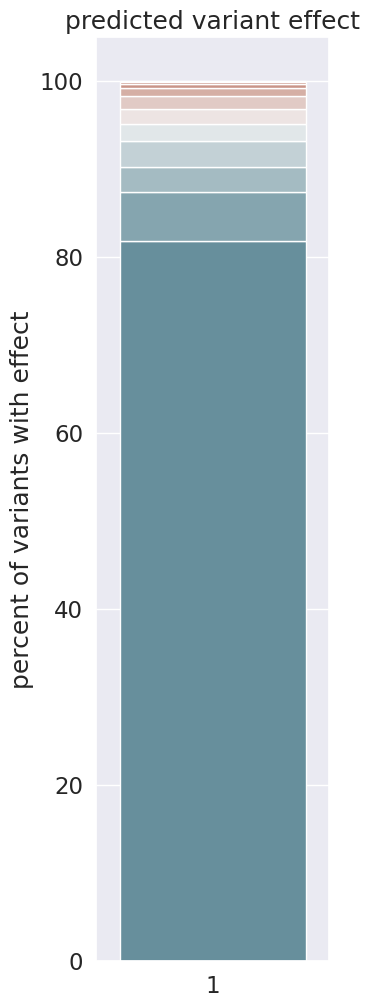

In [109]:
bottom = 0

for idx, (key, value) in enumerate(veps.items()):
    
    sns.set(rc={'figure.figsize':(3,12)})
    sns.set_style("white")
    
    sns.set(font_scale=1.5)
    
    sns.barplot(
        x=[1], 
        y=[value],
        color=sns.diverging_palette(220, 20, n=12)[1+idx],
        bottom = bottom
    )
    
    bottom = bottom + value
        
    plt.title('predicted variant effect')
    plt.xlabel(None)
    
    plt.ylabel('percent of variants with effect')
    
    
    
plt.savefig("vep.png")

In [ ]:
gts_over.aggregate_rows(hl.agg.counter(gt

In [68]:
maf_mt = sel_mt.filter_rows(sel_mt.gnomad_v_3_1.freq.AF[2] < 0.0001)

In [69]:
maf_mt.count()

(760, 278)

In [ ]:
sel_mt.aggregate_rows(hl.agg.approx_median(sel_mt.gnomad_v_3_1.freq.AF[2]))

In [28]:
gts_non_ref = sel_mt.filter_cols(
    (sel_mt.phenotypes.disease == 'NO') | (sel_mt.group == 'local_controls')
)

In [29]:
gts_non_ref = gts_non_ref.filter_rows(hl.agg.any(gts_non_ref.GT.is_non_ref()))

In [31]:
gts_non_ref.count()

(5997, 155)

In [ ]:
# count consequences

In [ ]:
# count how many variants in the maf model